In [19]:
import numpy as np
import cupy as cp
import json
import pickle
import pandas as pd
from collections import OrderedDict
import re
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
np.set_printoptions(threshold=sys.maxsize)
with open("word_count.json",'r') as f:
    w_json = json.load(f)
    word_count = OrderedDict(w_json)
class Skip_Gram:
    def __init__(self,word_count,window = 4,hidden_units = 300):
        self.window = window
        self.learningrate = 1e-12
        len_word = len(word_count)
        self.word_count = word_count
        self.hidden_units = hidden_units
        self.len_word = len_word
        self.reseter()
        self.Weight = {}
        self.Weight["W"+str(1)] = np.random.normal(-1., 1.,(len_word,hidden_units)) 
        self.Weight["W"+str(2)] = np.random.normal(-1., 1.,(hidden_units,len_word))
        # self.Weight["W"+str(1)] = np.random.randn(len_word,hidden_units)/2.5+1
        # self.Weight["W"+str(2)] = np.random.randn(len_word,hidden_units)
        # self.Weight["W"+str(2)] = np.random.randn(hidden_units,len_word)/2.5+1
    def reseter(self):
        self.onehoty = cp.zeros((self.len_word,1))
        self.onehotx = cp.zeros((self.len_word,1))
    def softmax(self, x):
        max_val = np.max(x)
        x = x - max_val
        # if np.isnan(x).any():
        #     print("NAN")
        #     print("\n",max_val,"\n")
        #     exit_op()
        #     exit()
        x = np.exp(x)
        self.soft = x/np.sum(x)
        return self.soft
    def linear_ohot(self,x,x1):
        self.iidx = self.word_count[re.sub(r'[^A-Za-z0-9\\]+','', x ).lower()][1]
        self.onehotx[self.iidx] +=1
        y = np.dot(self.onehotx.T,x1)
        return y
    def linear(self,x,x1):
        self.x_out = x
        y = np.dot(x,x1)
        return y
    def loss(self,y):    
        hadamard = np.multiply(np.log(y+1e-25),self.onehoty.T).T
        doter = np.dot(self.onehoty.T,hadamard)
        loss = -np.sum(doter)
        return loss
    def forward(self,x,y):
        x = self.linear_ohot(x,self.Weight['W1'])
        for idx,target in enumerate(y):
            self.onehoty[self.word_count[re.sub(r'[^A-Za-z0-9\\]+','', target ).lower()][1]] += 1 
        x = self.softmax(self.linear(x,self.Weight['W2']))
        y = self.loss(x)
        return y
    def backward(self,x):
        x =  self.soft - self.onehoty.T
        b = np.multiply(self.onehoty.T,x)
        dwo = np.dot(self.x_out.T,b)
        self.Weight['W2'] -= self.learningrate*dwo
        y = np.dot(self.Weight['W2'],x.T)
        dwi = np.multiply(self.onehotx.reshape(self.onehotx.shape[0],1),y.T)
        # if np.isnan(dwi).any():
        #     print(self.onehotx)
        self.Weight['W1'] -= self.learningrate*dwi
        self.reseter()
    def predict(self,x):
        x = self.linear_ohot(x,self.Weight['W1'])
        x = self.softmax(self.linear(x,self.Weight['W'+str(2)]))
        self.reseter()
        return x
    def ss(self,x):
        text = x
        x = self.linear_ohot(x,self.Weight['W1'])
        x_values = x[:,1]
        x = self.linear(x,self.Weight['W'+str(2)])
        y_values = x[:,1]
        self.reseter()
    
        plt.scatter(x_values.get(), y_values.get(), color='blue', s = 22,alpha=0.4)  # 'alpha' sets transparency
        plt.text(x_values.get(), y_values.get(), f'{text}', fontsize=10, color='black', ha='center', va='center',alpha=0.4)

In [20]:
with open("w2v_model.pkl","rb") as f:
    model = pickle.load(f)

In [21]:
word_lists = list(word_count.keys())

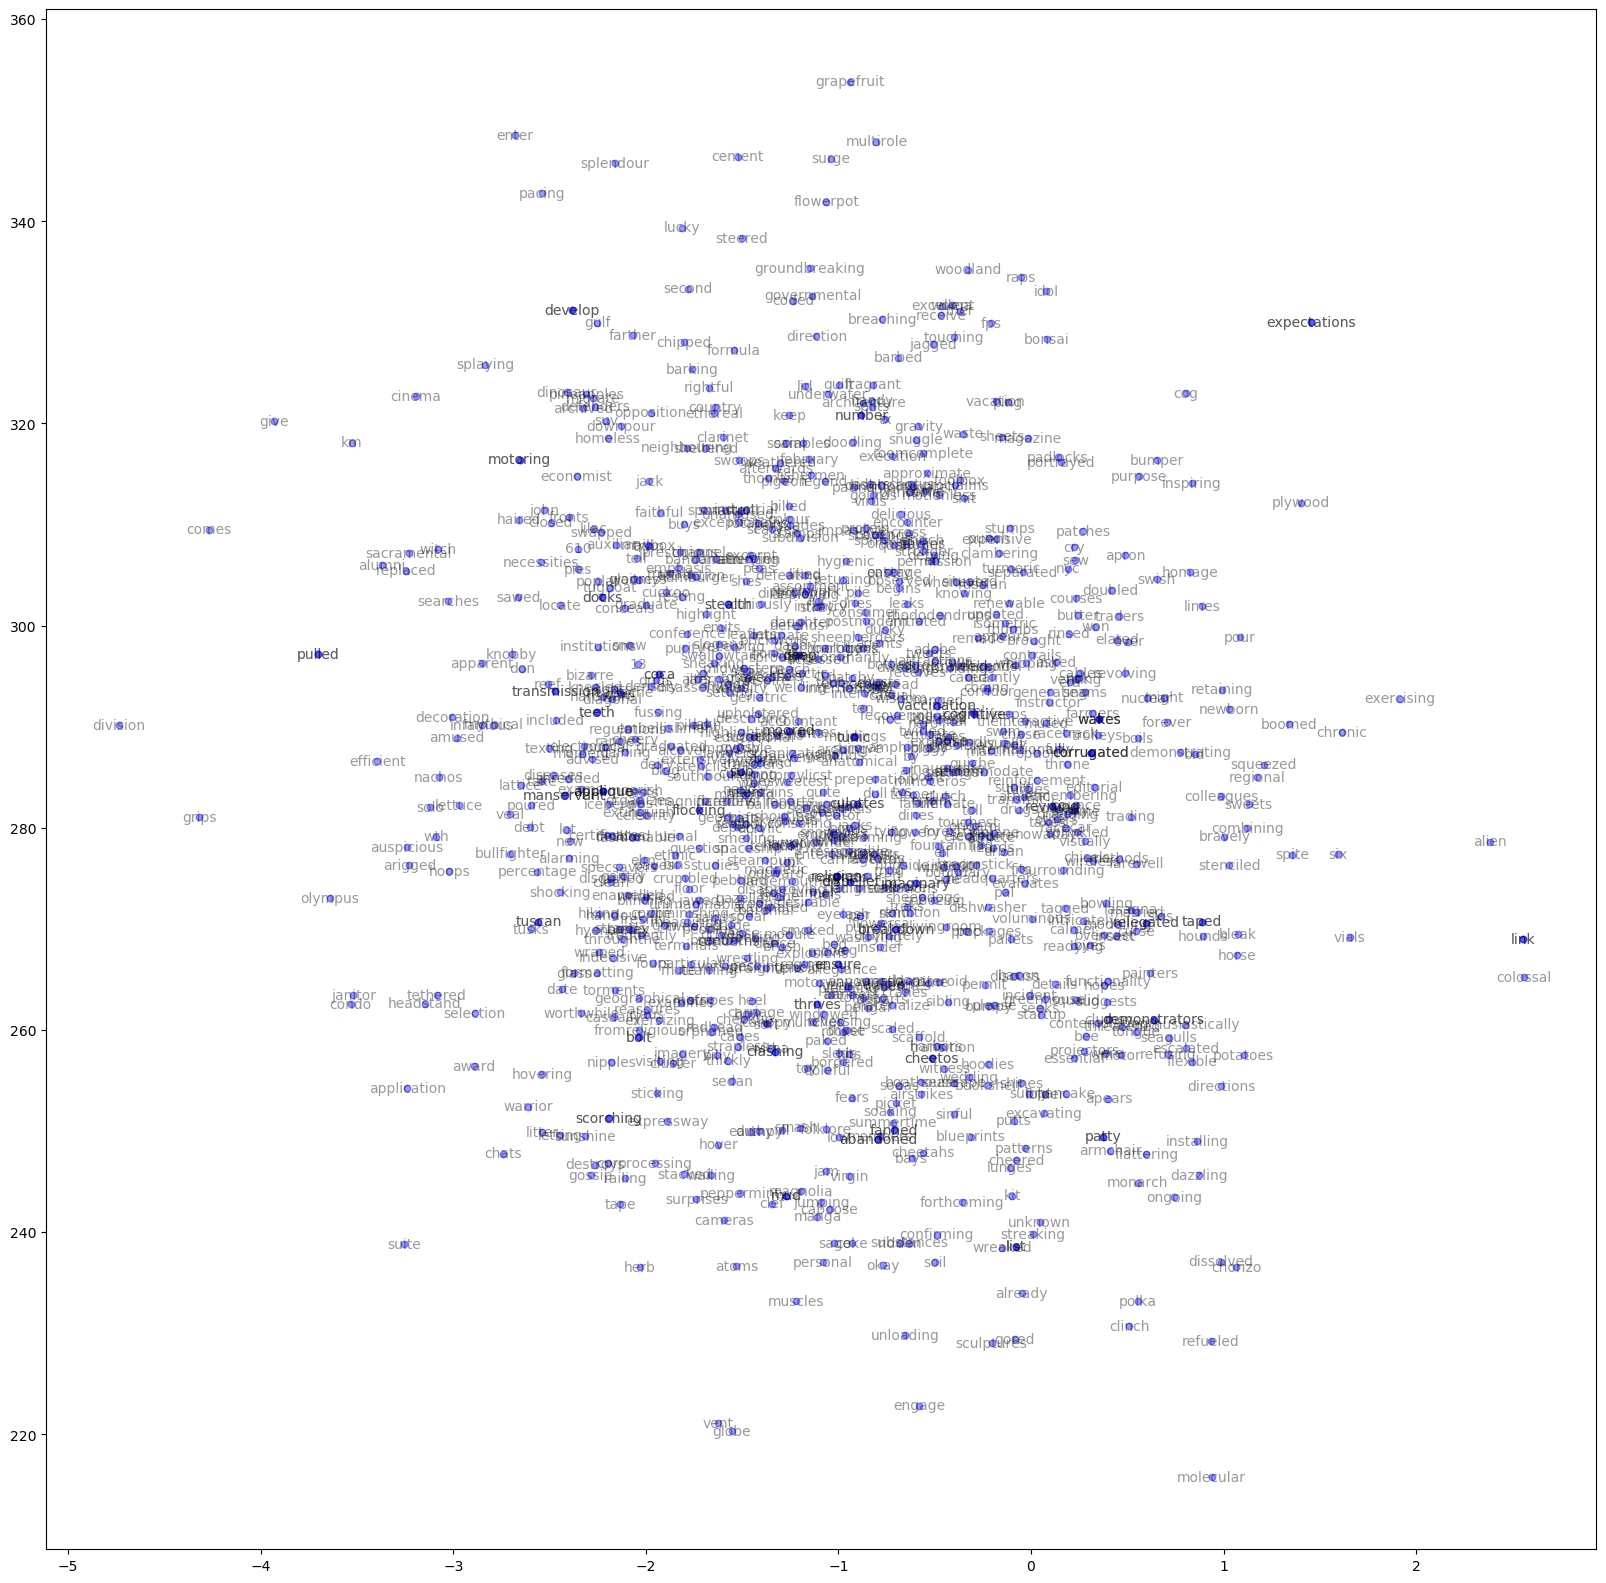

In [23]:
plt.figure(figsize=(20, 20))
# for _ in range(1000):
for word in ['dog','dogs','over','above']:
    # word = np.random.choice(word_lists)
    model.ss(word)

In [ ]:
plt.savefig('scatter_plot.png', dpi=5000, bbox_inches='tight')

: 